In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
print(os.listdir("../input"))
from matplotlib import pyplot as plt
import cv2
from PIL import Image
import random
from imgaug import augmenters as iaa

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model,Model
from keras.layers import Activation,Dropout,Flatten,Dense,Input,BatchNormalization,Conv2D
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras


['train', 'test', 'train.csv', 'sample_submission.csv']


Using TensorFlow backend.


 Some coding in this kernel is inspired(read blatantly stolen) from [this really great work](https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline) Also, suggestions are a welcome so far they are not about my grammer and spelling(which I admit is borderline horrible and there's no spell check in this environment)


# LET's EDA

Let's see the total available images in the dataset

In [2]:
df = pd.read_csv("../input/train.csv")
print("Total number of unique ids:",df.Id.count())
print("Total number of images:", df.Id.count()*4)

Total number of unique ids: 31072
Total number of images: 124288


In [3]:
df.head(2)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0


In [4]:
labels = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [5]:
for key in labels.keys():
    df[labels[key]] = 0
    
def filltargets(row):
    tar = row.Target.split(" ")
    for i in tar:
        col = labels[int(i)]
        row[str(col)]=1
    return row


In [6]:
df = df.apply(filltargets, axis=1)
df = df.drop(["Target"],axis = 1)

In [7]:
df.head(2)

,Id,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,Lysosomes,Intermediate filaments,Actin filaments,Focal adhesion sites,Microtubules,Microtubule ends,Cytokinetic bridge,Mitotic spindle,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Frequency of labels in the data

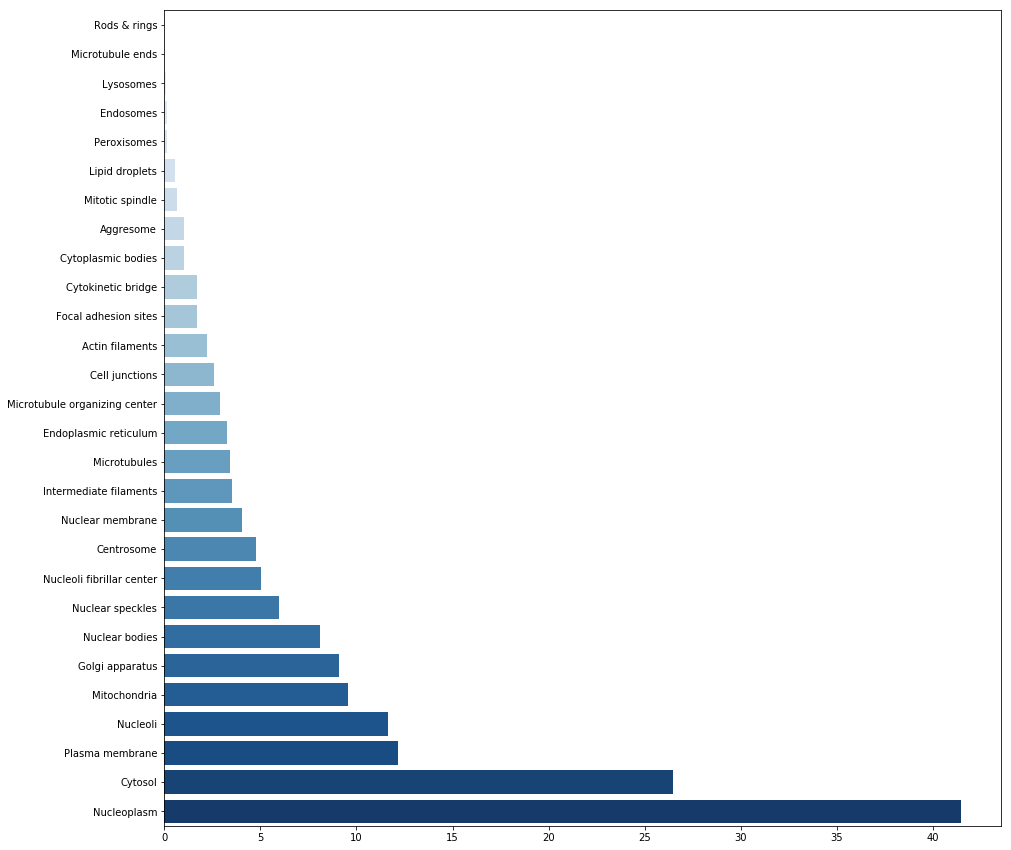

In [8]:
freq_df = df.drop(["Id"],axis=1).sum(axis=0).sort_values(ascending = True)
plt.figure(figsize=(15,15))
sns.barplot(y=freq_df.index.values, x=freq_df.values*100/len(df), order=freq_df.index,palette="Blues")


Insights: 

* Nucleoplasm is the most common occurance (>40%) followed by Cytosol (>27%)
* Plasma Membrane, Nucleoli, Mitochondria(Power-house of the cell) and other relatively bigger objects are present in a quantity that may not surprise any one who knows the basic cell structure.
* The most interesting things in the distribution  of less frequent objects such as Rods and Rings, Microtubules Ends, Lysosomes etc as compared to those of Nucleoplasm. Hence a clear classs imbalance that can lead to harmful bias in model. This also gives us the idea about the kind of metric that we might endup using. From my very limited knowledge I think it should be F1.


## The grouping of labels

Let's see the grouping of the least frequent variables first.

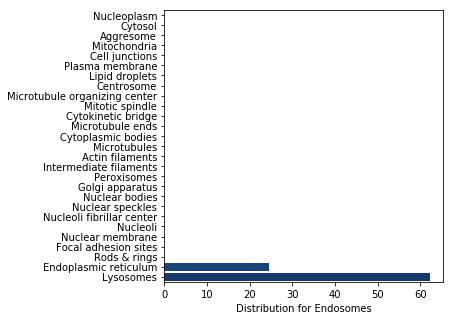

In [9]:
def correlated_distribution(label):
    df_ = df[df[label]==1]
    freq_df = df_.drop(["Id",label],axis=1).sum(axis=0).sort_values(ascending = True)
    plt.figure(figsize=(5,5))
    plt.xlabel("Distribution for "+label)
    sns.barplot(y=freq_df.index.values, x=freq_df.values*100/len(df_), order=freq_df.index,palette="Blues")

correlated_distribution("Endosomes")

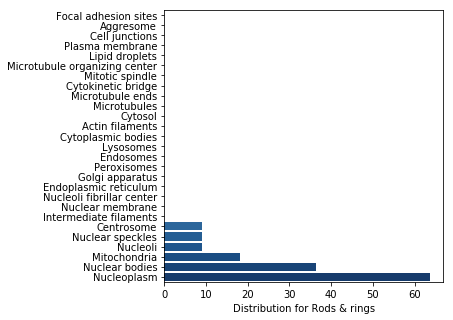

In [10]:
correlated_distribution("Rods & rings")

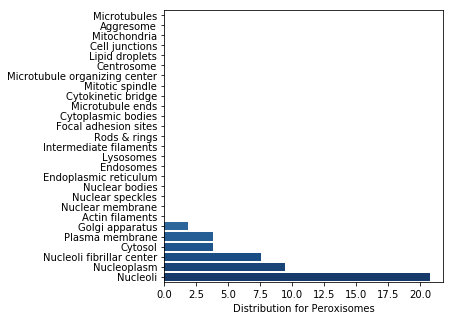

In [11]:
correlated_distribution("Peroxisomes")

Let's see the grouping of most frequent labels

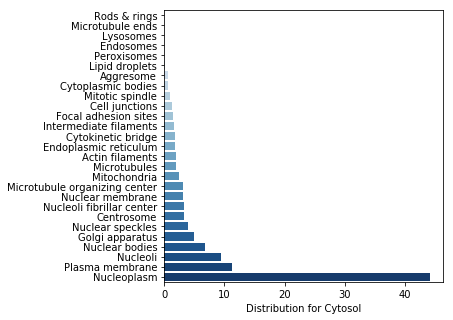

In [12]:
correlated_distribution("Cytosol")

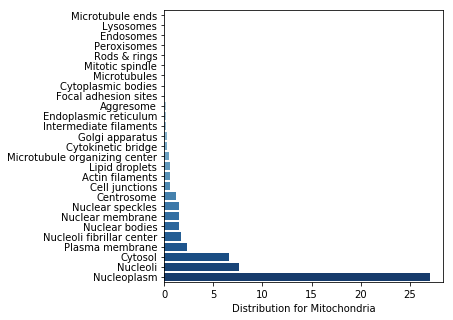

In [13]:
correlated_distribution("Mitochondria")

Hmm... Interesting!


The key insight here is that the more frequent labels occure in more spread-out manner, i.e, they seems to be partnering up with way more variables while the least frequent variables are loyal to a small number of labels.

Work in progress...

# Multilabel Analysis

Text(0,0.5,'% of data')

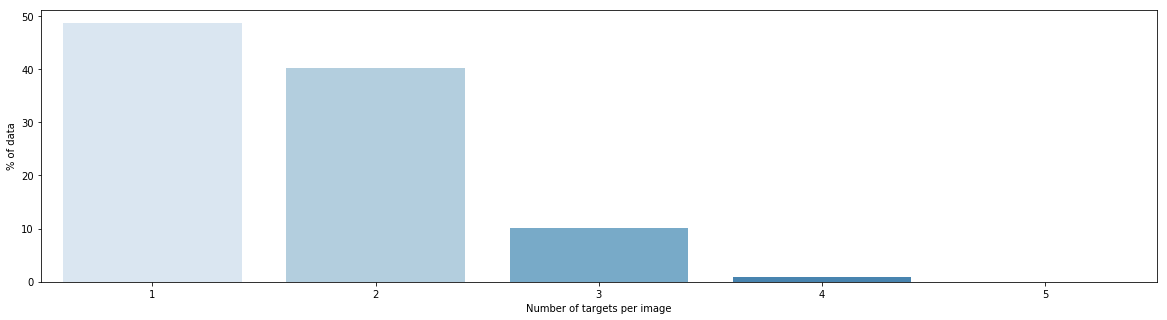

In [14]:
freq_df = pd.DataFrame()
freq_df["number_of_targets"] = df.drop(["Id"],axis=1).sum(axis=1).sort_values(ascending = True)
count_perc = np.round(100 * freq_df["number_of_targets"].value_counts() / freq_df.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Blues")
plt.xlabel("Number of targets per image")
plt.ylabel("% of data")

Okay so majority is either single or double labeled. 

In [ ]:
shape = (299,299)

def load_image(id,path="../input/train/"):
    global shape
    R = np.array(Image.open(path+id+'_red.png'))
    G = np.array(Image.open(path+id+'_green.png'))
    B = np.array(Image.open(path+id+'_blue.png'))
    Y = np.array(Image.open(path+id+'_yellow.png'))

    image = np.stack((
        R/2+Y/2,
        G/2+Y/2, 
        B),-1)

    image = cv2.resize(image, (shape[0], shape[1]))
    image = np.divide(image, 255)
    return image  

plt.figure(figsize=(25,15))
for n in range(4):
    idx = np.random.randint(0,20000,1)
    im_name = df.Id[idx[0]]
    im = load_image(im_name)
    plt.subplot(1,4,n+1)
    plt.imshow(im)
plt.show()
